# I. Libraries

In [1]:
import sys
import text_flappy_bird_gym
import gymnasium as gym
import torch
import torch.nn as nn
from collections import deque
import random
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools
from itertools import product
import seaborn as sns
import pandas as pd

# II. Train agents

In [2]:
# Function to compute moving average
def moving_average(values, window_size):
    """Compute the moving average of a list of values with a specified window size."""
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid')

In [80]:
def plot_correlation(results):
    """
    Plots the correlation between hyperparameters and the score.
    """
    data = []
    for res in results:
        row = res["params"].copy()
        row["score"] = res["score"]
        data.append(row)

    df = pd.DataFrame(data)

    # Convert categorical parameters to numeric for correlation analysis
    for col in df.columns:
        if df[col].dtype == 'O':  # Object type (categorical)
            df[col] = pd.factorize(df[col])[0]

    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()

## A. Monte-Carlo

### 1. Basic

In [5]:
class MonteCarloAgent:
    """
    Monte Carlo Control Agent using the first-visit method with epsilon-greedy policy.
    """

    def __init__(self):
        """Initializes all variables to None for proper agent setup in agent_init."""
        self.Q = None
        self.returns = None
        self.epsilon = None
        self.gamma = None
        self.alpha = None
        self.epsilon_end = None
        self.epsilon_decay = None
        self.alpha_decay = None
        self.env = None
        self.episodes = None
        self.reward_history = None

    def agent_init(self, agent_info={}):
        """
        Initializes the Monte Carlo Agent with the given parameters.&
        """
        self.episodes = agent_info.get("episodes", 5000)
        self.gamma = agent_info.get("gamma", 0.99)
        self.epsilon = agent_info.get("epsilon_start", 1.0)
        self.epsilon_end = agent_info.get("epsilon_end", 0.1)
        self.epsilon_decay = agent_info.get("epsilon_decay", 0.995)
        self.alpha = agent_info.get("alpha_start", 0.1)
        self.alpha_decay = agent_info.get("alpha_decay", 0.999)
        self.env = agent_info.get("env")

        # Initialize Q-table and returns dictionary
        self.Q = defaultdict(lambda: np.zeros(self.env.action_space.n))
        self.returns = defaultdict(list)
        self.reward_history = []

    def select_action(self, state):
        """
        Selects an action using an epsilon-greedy policy.
        """
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.Q[state])

    def train(self):
        """
        Trains the agent using Monte Carlo first-visit control with epsilon-greedy.
        """
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            state = tuple(state)
            episode_memory = []
            done = False
            episode_reward = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                next_state = tuple(next_state)
                episode_memory.append((state, action, reward))
                state = next_state
                episode_reward += reward

            self.reward_history.append(episode_reward)

            # Monte Carlo Update
            G = 0
            visited_state_actions = set()
            for state, action, reward in reversed(episode_memory):
                G = reward + self.gamma * G
                if (state, action) not in visited_state_actions:
                    visited_state_actions.add((state, action))
                    self.returns[(state, action)].append(G)
                    self.Q[state][action] += self.alpha * (G - self.Q[state][action])

            # Decay epsilon and alpha
            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
            self.alpha = max(0.0001, self.alpha * self.alpha_decay)

        return self.Q, self.reward_history

    def agent_start(self, state):
        """
        Starts the agent by selecting an action based on the initial state.
        """
        state = tuple(state)
        return self.select_action(state)

    def agent_step(self, reward, state):
        """
        Not used in Monte Carlo but included for consistency with the SarsaAgent structure.
        """
        state = tuple(state)
        return self.select_action(state)

    def agent_end(self, reward):
        """
        Handles the end of an episode.
        """
        pass  # Monte Carlo updates happen at the end of each episode

    def agent_cleanup(self):
        """Cleans up after the agent ends an episode."""
        pass

    def agent_message(self, message):
        """
        Handles messages between the agent and external components.
        """
        if message == "get_Q":
            return self.Q
        elif message == "get_rewards":
            return self.reward_history
        else:
            return "Message not understood."

    def get_policy(self):
        """
        Extracts the optimal policy from the learned Q-values.
        """
        return {state: np.argmax(actions) for state, actions in self.Q.items()}


In [17]:
class GridSearch_MC:
    def __init__(self, agent_class, env, param_grid, episodes=5000):
        """
        Initializes the grid search with the agent class, environment, and hyperparameter grid.
        """
        self.agent_class = agent_class
        self.env = env
        self.param_grid = param_grid
        self.episodes = episodes
        self.results = []

    def run_experiment(self, params):
        """
        Runs a single experiment with a given set of hyperparameters.
        """
        agent = self.agent_class()
        params = {k: v for k, v in params.items() if k not in ["env", "episodes"]}  # Remove env and episodes
        params["env"] = self.env  # Ensure environment is passed
        params["episodes"] = self.episodes  # Ensure episode count matches grid search
        agent.agent_init(params)
        
        _, reward_history = agent.train()

        return np.mean(reward_history[-100:])

    def search(self):
        """
        Performs a grid search over the given parameter grid and returns all results as a dictionary.
        """
        keys, values = zip(*self.param_grid.items())
        param_combinations = list(itertools.product(*values))
        
        all_results = []
        best_params = None
        best_reward = -np.inf

        with tqdm(total=len(param_combinations), desc="Grid Search Progress") as pbar:
            for param_values in param_combinations:
                params = dict(zip(keys, param_values))
                avg_reward = self.run_experiment(params)
                
                filtered_params = {k: v for k, v in params.items() if k not in ["env", "episodes"]}  # Exclude env and episodes
                all_results.append({"params": filtered_params, "score": avg_reward})
                
                if avg_reward > best_reward:
                    best_reward = avg_reward
                    best_params = filtered_params
                
                pbar.update(1)  # Update progress bar

        print(f"\nBest Params: {best_params} | Best Reward: {best_reward}")
        return all_results

In [18]:
# Run Grid Search on Flappy Bird
env = gym.make('TextFlappyBird-v0')

# Define parameter grid
param_grid = {
    "gamma": [0.8, 0.9, 0.99],
    "epsilon_start": [1.0, 0.8, 0.5],
    "epsilon_end": [0.1, 0.05], 
    "epsilon_decay": [0.995, 0.999],
    "alpha_start": [0.1, 0.01, 0.001],
    "alpha_decay": [0.999, 0.995]
}

# Run Grid Search for Monte Carlo Agent
grid_search_mc = GridSearch_MC(MonteCarloAgent, env, param_grid, episodes=10_000)
results_MCBasic = grid_search_mc.search()

Grid Search Progress: 100%|██████████| 216/216 [07:45<00:00,  2.16s/it]


Best Params: {'gamma': 0.9, 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay': 0.995, 'alpha_start': 0.1, 'alpha_decay': 0.999} | Best Reward: 198.93


**Result of grid search for Monte Carlo Basic agent:**

Best Params: {'gamma': 0.9, 'epsilon_start': 1, 'epsilon_end': 0.05, 'epsilon_decay': 0.995, 'alpha_start': 0.1, 'alpha_decay': 0.999}

Best Reward: 198.93

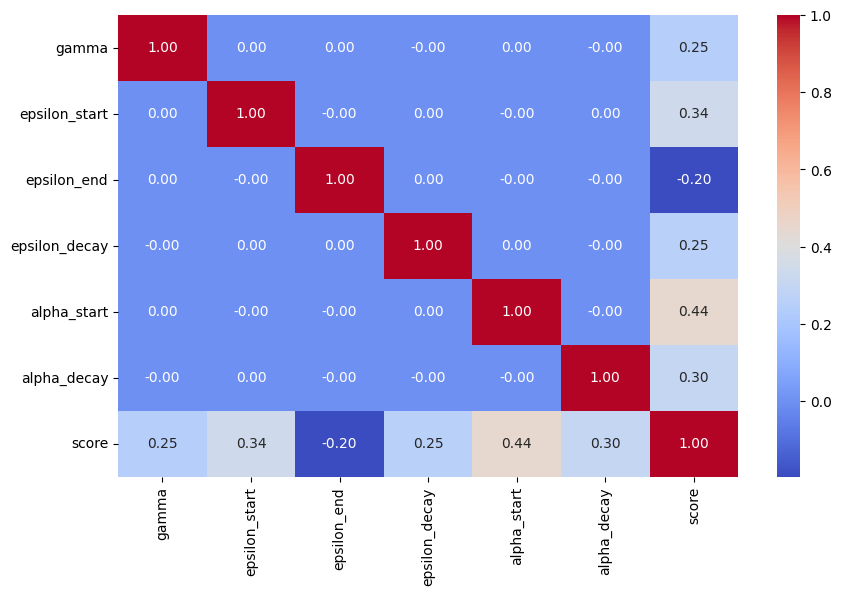

In [81]:
plot_correlation(results_MCBasic)

In [101]:
# Run the Monte Carlo agent
env = gym.make('TextFlappyBird-v0')
episodes = 10000

agent = MonteCarloAgent()
agent.agent_init({'env':env,'episodes':episodes, 'gamma': 0.9, 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay': 0.995, 'alpha_start': 0.1, 'alpha_decay': 0.999})
trained_policy, reward_history_mc_basic = agent.train()

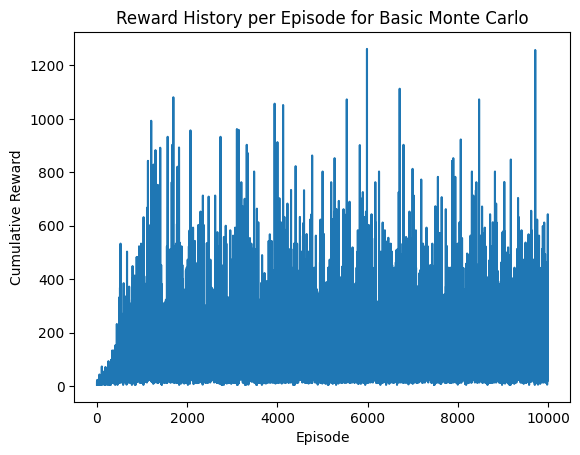

In [102]:
plt.plot(reward_history_mc_basic)
plt.title("Reward History per Episode for Basic Monte Carlo")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.show()

Results difficult to read because of instability, let's apply a smoothening (here moving average):

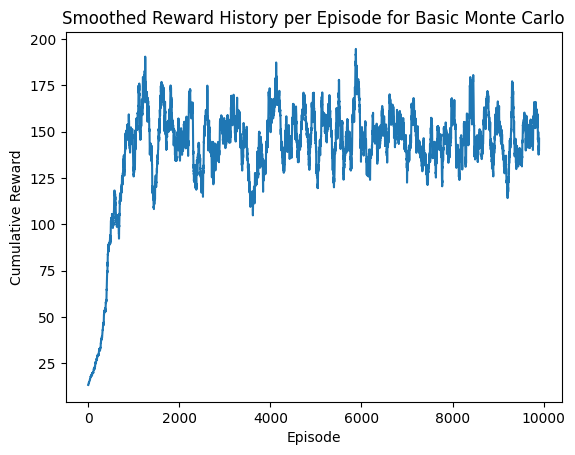

In [103]:
window_size = 100
smoothed_rewards_mc_basic = moving_average(reward_history_mc_basic, window_size)

plt.plot(smoothed_rewards_mc_basic)
plt.title("Smoothed Reward History per Episode for Basic Monte Carlo")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.show()

Pretty good results and seems to converge pretty quicly but still a bit unstable even with smoothening

### 2. Reinforced

In [ ]:
# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# Monte Carlo REINFORCE Agent
class MonteCarloAgentReinforced:
    def __init__(self, input_dim, output_dim, lr=0.005, gamma=0.98):
        self.policy = PolicyNetwork(input_dim, output_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.memory = []
        self.total_reward = 0  # Track the total reward
    
    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs = self.policy(state)
        action = torch.multinomial(probs, 1).item()
        return action, torch.log(probs[action])
    
    def store_transition(self, log_prob, reward):
        # Update the total reward and check if it exceeds the threshold
        self.total_reward += reward
        self.memory.append((log_prob, reward))
    
    def update_policy(self):
        R = 0
        policy_loss = []
        returns = []
        
        for _, reward in reversed(self.memory):
            R = reward + self.gamma * R
            returns.insert(0, R)
        
        returns = torch.tensor(returns, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)
        
        for (log_prob, R) in zip(self.memory, returns):
            policy_loss.append(-log_prob[0] * R)
        
        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum()
        loss.backward()
        self.optimizer.step()
        self.memory = []

In [ ]:
class GridSearch_MCReinforced:
    def __init__(self, agent_class, param_grid, env, epochs=50):
        self.agent_class = agent_class
        self.param_grid = param_grid
        self.env = env
        self.epochs = epochs

    def grid_search(self):
        # Create all combinations of parameters
        param_combinations = list(itertools.product(*self.param_grid.values()))
        best_params = None
        best_avg_reward = -float('inf')

        # Track results as a list of dictionaries
        results = []

        # Iterate over all parameter combinations
        for params in tqdm(param_combinations, desc="Grid Search Progress"):
            # Map parameters to the grid
            params_dict = dict(zip(self.param_grid.keys(), params))
            lr = params_dict['lr']
            gamma = params_dict['gamma']
            smoothing_factor = params_dict['smoothing_factor']

            # Initialize agent with current parameters
            agent = self.agent_class(input_dim=2, output_dim=2, lr=lr, gamma=gamma)

            # Training loop
            total_rewards = []
            for episode in range(self.epochs):
                state, _ = self.env.reset()
                done = False
                total_reward = 0

                while not done:
                    action, log_prob = agent.select_action(state)
                    next_state, reward, done, _, _ = self.env.step(action)
                    agent.store_transition(log_prob, reward)
                    state = next_state
                    total_reward += reward

                agent.update_policy()
                total_rewards.append(total_reward)

            avg_reward = np.mean(total_rewards)

            # Store the parameters and corresponding score in the desired format
            results.append({
                'params': params_dict,
                'score': avg_reward
            })

            # Update best parameters
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                best_params = params_dict

        # Print and return the results
        print(f"Best Parameters: {best_params}")
        print(f"Best Average Reward: {best_avg_reward}")
        return results


In [30]:
env = gym.make('TextFlappyBird-v0')
param_grid = {
    'lr': [0.0001, 0.001],  # Learning rates to try
    'gamma': [0.80, 0.9, 0.98],  # Discount factors to try
    'smoothing_factor': [ 0.9, 0.99]  # Smoothing factors for EMA
}

# Create a GridSearch object
grid_search = GridSearch_MCReinforced(
    agent_class=MonteCarloAgentReinforced, 
    param_grid=param_grid, 
    env=env, 
    epochs=500  # Set number of episodes to train for each configuration
)

# Run the grid search
results_MCReinforced = grid_search.grid_search()

Grid Search Progress: 100%|██████████| 12/12 [03:25<00:00, 17.15s/it]

Best Parameters: {'lr': 0.001, 'gamma': 0.8, 'smoothing_factor': 0.99}
Best Average Reward: 798.51


**Result of grid search for Monte Carlo Reinforced agent:**

Best Parameters: {'lr': 0.001, 'gamma': 0.8, 'smoothing_factor': 0.99}

Best Average Reward: 798.51

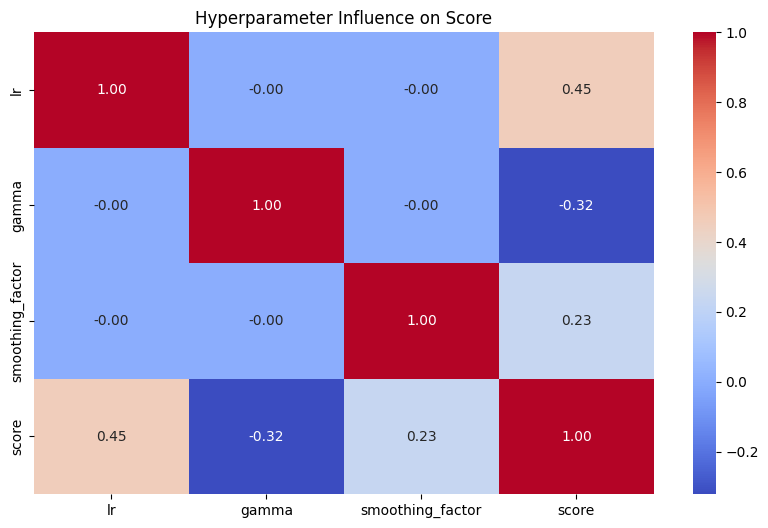

In [42]:
plot_correlation(results_MCReinforced)

In [32]:
# Training Loop
env = gym.make('TextFlappyBird-v0')
num_episodes = 1000
rewards_history_mc_reinforced = []

agent = MonteCarloAgentReinforced(input_dim=2, output_dim=2, lr=0.001, gamma=0.8)
smoothing_factor = 0.99
reward_threshold = 100_000

for episode in tqdm(range(num_episodes)):
    state, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action, log_prob = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.store_transition(log_prob, reward)
        state = next_state
        total_reward += reward
    
    agent.update_policy()

    rewards_history_mc_reinforced.append(total_reward)

    
    if total_reward>=reward_threshold:
        break
    #print(f"Episode {episode+1}, Total Reward: {total_reward}")
    # if total_reward>100_000:
    #     print("Reaching limit of reward before limit of episode")
    #     break

env.close()

 88%|████████▊ | 876/1000 [27:20<03:52,  1.87s/it]


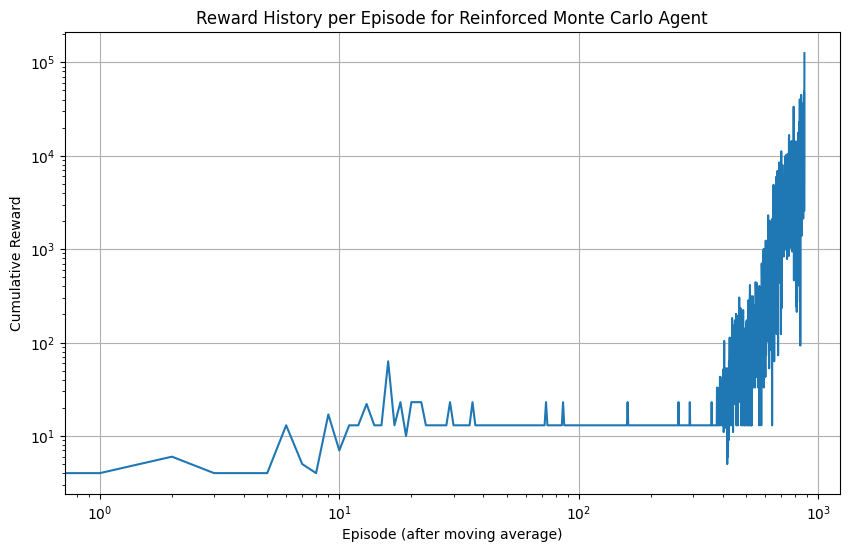

In [69]:
plt.figure(figsize=(10, 6))
plt.loglog(rewards_history_mc_reinforced)
plt.title("Reward History per Episode for Reinforced Monte Carlo Agent")
plt.xlabel("Episode (after moving average)")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.show()

We can clearly see that the agent learn way better that the original and seems a bit more table but learn suddnely after some  epochs (around 700)

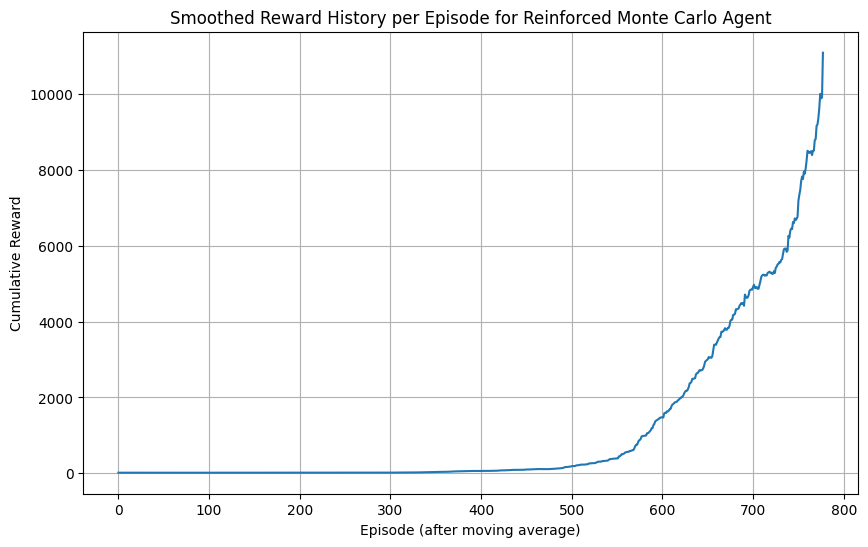

In [71]:
# Apply the moving average with a window size of 100
window_size = 100
smoothed_rewards_mc_reinforced = moving_average(rewards_history_mc_reinforced, window_size)

# Plot the smoothed reward history
plt.figure(figsize=(10, 6))
plt.plot(smoothed_rewards_mc_reinforced)
plt.title("Smoothed Reward History per Episode for Reinforced Monte Carlo Agent")
plt.xlabel("Episode (after moving average)")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.show()

With the moving average applied we can clearly observe this exponential learning that is way better than the basic form

## Sarsa Agent

In [ ]:
class SarsaAgent:
    def __init__(self):
        self.q_table = None  # Q-values stored in a dictionary or array
        self.epsilon = None  # Exploration rate
        self.alpha = None  # Learning rate
        self.gamma = None  # Discount factor
        self.num_actions = None  # Number of actions in environment
        self.last_state = None
        self.last_action = None

    def agent_init(self, agent_info):
        """Initialize agent parameters."""
        self.num_actions = agent_info.get("num_actions", 3)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.alpha = agent_info.get("alpha", 0.5)
        self.gamma = agent_info.get("gamma", 0.99)
        self.q_table = {}  # Dictionary-based Q-table (state-action values)

    def select_action(self, state):
        """Selects an action using epsilon-greedy strategy."""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.num_actions)  # Initialize new state

        if np.random.rand() < self.epsilon:  # Exploration
            return np.random.choice(self.num_actions)
        else:  # Exploitation
            return np.argmax(self.q_table[state])

    def agent_start(self, state):
        """Start a new episode by selecting an action for the first state."""
        action = self.select_action(state)
        self.last_state = state
        self.last_action = action
        return action

    def agent_step(self, reward, state):
        """Updates Q-table and selects the next action."""
        action = self.select_action(state)  # Choose next action
        
        # Initialize new state in Q-table if necessary
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.num_actions)

        # SARSA update rule
        old_value = self.q_table[self.last_state][self.last_action]
        next_q = self.q_table[state][action]
        self.q_table[self.last_state][self.last_action] += self.alpha * (reward + self.gamma * next_q - old_value)

        self.last_state = state
        self.last_action = action
        return action

    def agent_end(self, reward):
        """Update the Q-table for the last step in the episode."""
        old_value = self.q_table[self.last_state][self.last_action]
        self.q_table[self.last_state][self.last_action] += self.alpha * (reward - old_value)

    def agent_cleanup(self):
        """Resets agent state for a new episode."""
        self.last_state = None
        self.last_action = None


In [ ]:
class GridSearchSarsa:
    def __init__(self, env, agent_class, param_grid, num_episodes):
        self.agent_class = agent_class
        self.env = env
        self.param_grid = param_grid
        self.num_episodes = num_episodes
        self.best_params = None
        self.best_score = float('-inf')

    def run_sarsa(self, agent, env):
        """Runs the SARSA agent in the environment and returns the average score."""
        total_rewards = []
        for _ in range(self.num_episodes):
            state, _ = env.reset()
            action = agent.agent_start(state)
            episode_reward = 0
            done = False

            while not done:
                next_state, reward, done, _, _ = env.step(action)
                if not done:
                    action = agent.agent_step(reward, next_state)
                else:
                    agent.agent_end(reward)
                episode_reward += reward

            total_rewards.append(episode_reward)
        return np.mean(total_rewards)

    def perform_grid_search(self):
        """Performs Grid Search to find the best hyperparameters for SARSA."""
        param_combinations = list(product(self.param_grid['epsilon'], self.param_grid['alpha'], self.param_grid['gamma']))
        
        # Store results as a list of dictionaries
        results = []

        for params in tqdm(param_combinations, desc="Grid Search Progress", unit="param set"):
            epsilon, alpha, gamma = params
            # Initialize the agent with current parameters
            agent = self.agent_class()
            agent.agent_init({"num_actions": 2, "epsilon": epsilon, "alpha": alpha, "gamma": gamma})
            
            # Run SARSA and get the average reward
            env = self.env
            avg_reward = self.run_sarsa(agent, env)
            env.close()

            # Store the parameters and corresponding score in the desired format
            results.append({
                'params': {
                    'epsilon': epsilon,
                    'alpha': alpha,
                    'gamma': gamma
                },
                'score': avg_reward
            })

            # Update best parameters
            if avg_reward > self.best_score:
                self.best_score = avg_reward
                self.best_params = params

        # Print and return the results
        print(f"Best Params: epsilon={self.best_params[0]}, alpha={self.best_params[1]}, gamma={self.best_params[2]} with Avg Reward: {self.best_score}")

        return results  # Return the list of parameter-score dictionaries


In [46]:
env = gym.make('TextFlappyBird-v0')
# Define grid search parameters
param_grid = {
    'epsilon': [0.01, 0.1, 0.2],
    'alpha': [0.1, 0.5, 0.9],
    'gamma': [0.9, 0.99, 1.0]
}
num_episodes = 5000

# Example usage
grid_search = GridSearchSarsa(env, SarsaAgent, param_grid, num_episodes)
results_Sarsa = grid_search.perform_grid_search()

Grid Search Progress: 100%|██████████| 27/27 [00:53<00:00,  1.98s/param set]

Best Params: epsilon=0.1, alpha=0.5, gamma=1.0 with Avg Reward: 55.9888


**Result of grid search for Sarsa agent:**

Best Params: epsilon=0.1, alpha=0.5, gamma=1

Avg Reward: 55.9888

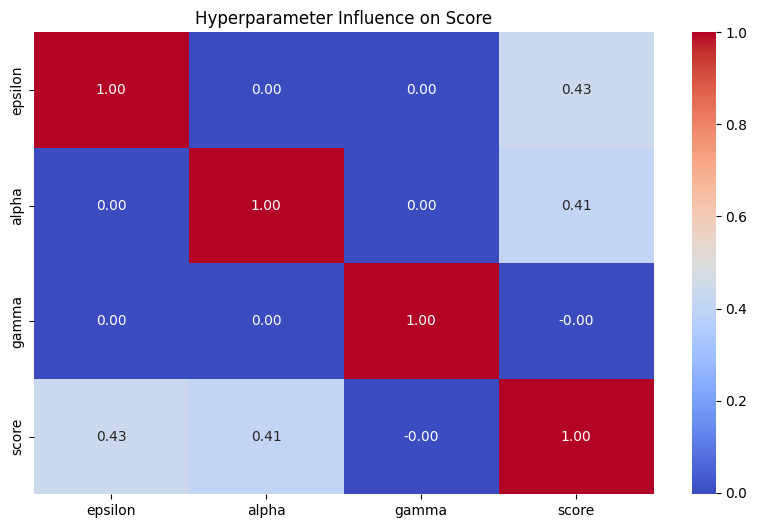

In [47]:
plot_correlation(results_Sarsa)

In [88]:
env = gym.make('TextFlappyBird-v0')
agent = SarsaAgent()
agent.agent_init({"num_actions": 2, "epsilon": 0.1, "alpha": 1.0, "gamma": 1})

# Initialize list to store rewards per episode
sarsa_reward_history = []

# Run for 5000 episodes
num_epochs = 10000
for episode in tqdm(range(num_epochs)):
    state, _ = env.reset()
    action = agent.agent_start(state)

    # Run the agent for one full episode
    done = False
    episode_reward = 0

    while not done:
        next_state, reward, done, _, _ = env.step(action)
        action = agent.agent_step(reward, next_state) if not done else agent.agent_end(reward)
        episode_reward += reward

    # Append the reward for the current episode to the history
    sarsa_reward_history.append(episode_reward)

env.close()

100%|██████████| 10000/10000 [00:06<00:00, 1559.87it/s]


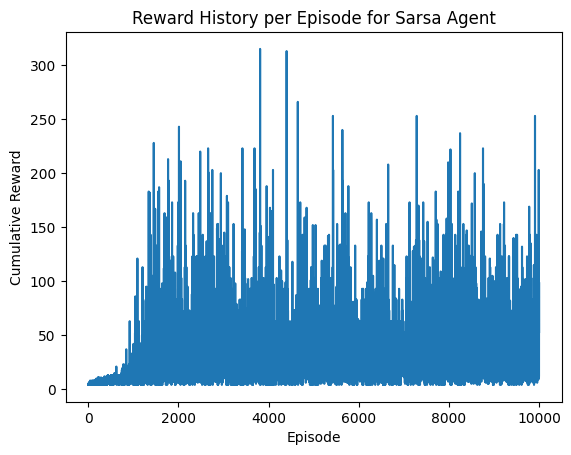

In [89]:
plt.plot(sarsa_reward_history)
plt.title("Reward History per Episode for Sarsa Agent")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.show()

Same as Monte Carlo Basic, difficult to read so let's apply the moving average

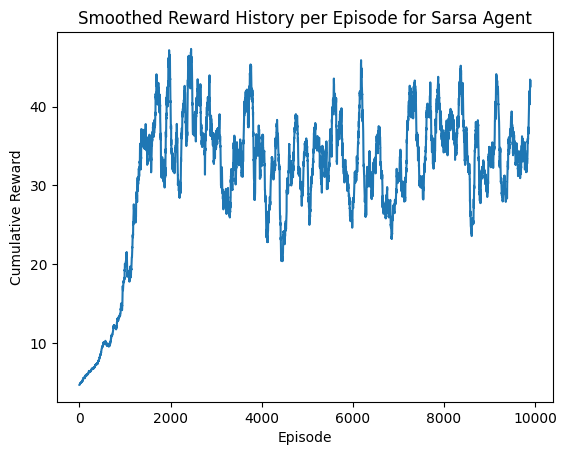

In [90]:
window_size = 100
smoothed_rewards_sarsa = moving_average(sarsa_reward_history, window_size)

plt.plot(smoothed_rewards_sarsa)
plt.title("Smoothed Reward History per Episode for Sarsa Agent")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.show()

We can see here that the results a bit similar to the monte Carlo Basic but in worse in terms of instability but also in terms of cumulative reward in the converged value

# Results comparison

C:\Users\galdw\AppData\Local\Temp\ipykernel_31632\3595543421.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Agent', y='Score', data=df, palette="Set3")


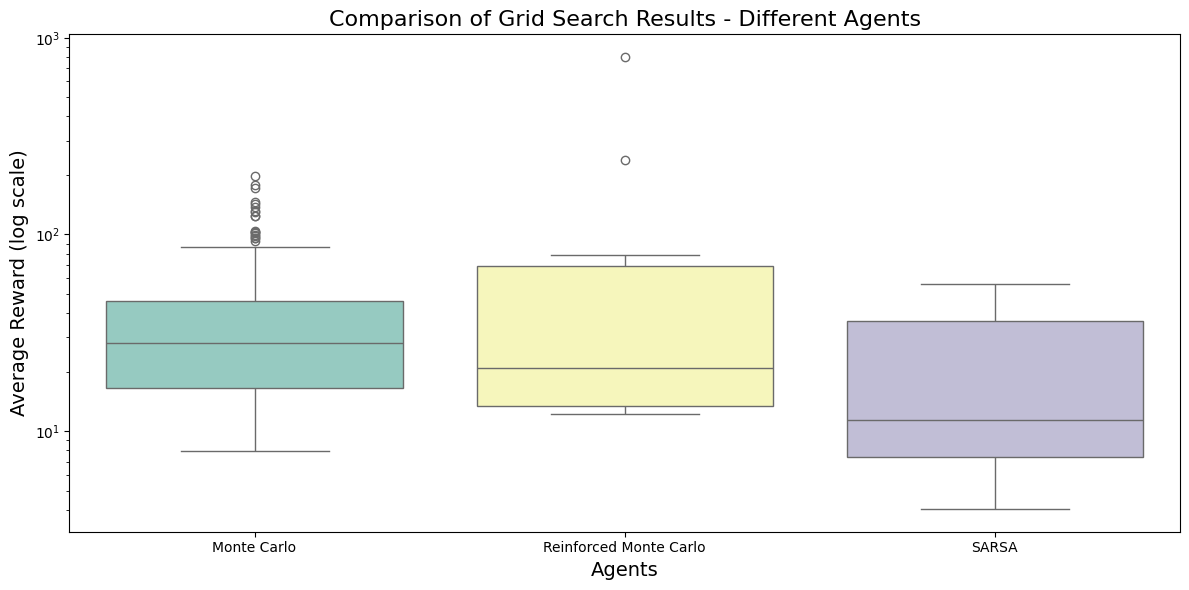

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_comparison_loglog(results_mc, results_rm, results_sarsa):
    # Prepare data for plotting
    data = []
    
    # Extract scores for Monte Carlo
    for result in results_mc:
        data.append({'Agent': 'Monte Carlo', 'Score': result['score']})

    # Extract scores for Reinforced Monte Carlo
    for result in results_rm:
        data.append({'Agent': 'Reinforced Monte Carlo', 'Score': result['score']})

    # Extract scores for SARSA
    for result in results_sarsa:
        data.append({'Agent': 'SARSA', 'Score': result['score']})

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Create the box plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Agent', y='Score', data=df, palette="Set3")

    # Set the title and labels
    plt.title("Comparison of Grid Search Results - Different Agents", fontsize=16)
    plt.xlabel("Agents", fontsize=14)
    plt.ylabel("Average Reward (log scale)", fontsize=14)
    
    # Apply log scale on the y-axis
    plt.yscale('log')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage: assuming you have the grid search results for the three agents
plot_comparison_loglog(results_MCBasic, results_MCReinforced, results_Sarsa)


In the training, the Monte Carlo Reinforced agent exhibits a wider range, indicating higher variance but also potential for
superior performance.

The SARSA agent shows more consistency but lower median rewards.

In [92]:
def plot_log_comparison_reward_histories(curves, legend_labels=None, x_values=None):
    plt.figure(figsize=(10, 6))
    
    if x_values is None:
        x_values = [np.arange(1, len(curve) + 1) for curve in curves]
    
    for i, curve in enumerate(curves):
        label = legend_labels[i] if legend_labels is not None else f'Curve {i+1}'
        plt.plot(x_values[i], curve, label=label)
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.title("Comparison of Evolution of Learning Between Agents")
    
    plt.legend()
    
    plt.tight_layout()
    plt.show()

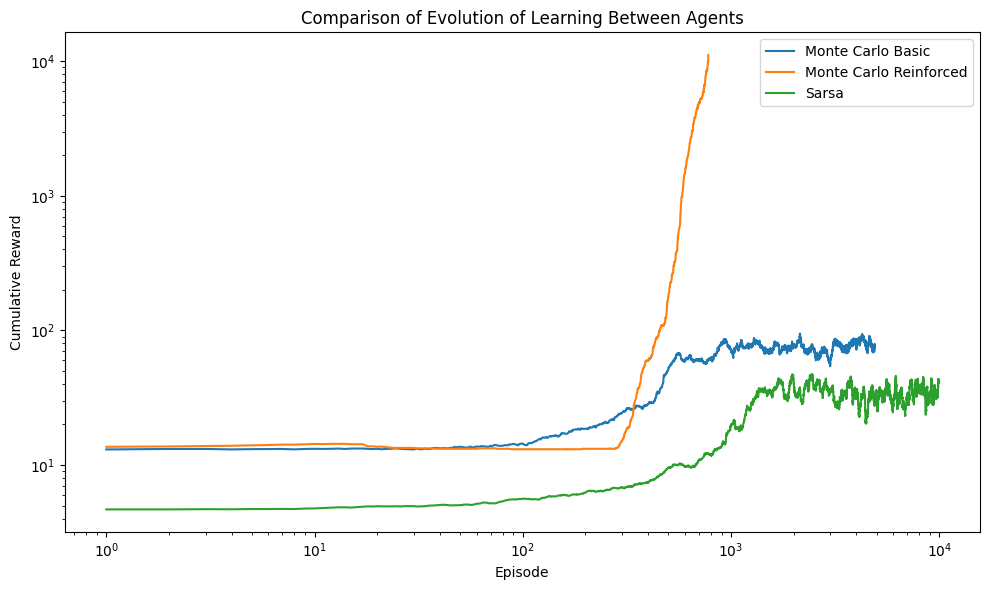

In [97]:
all_rewards_histories = [smoothed_rewards_mc_basic,smoothed_rewards_mc_reinforced,smoothed_rewards_sarsa]
agent_labels = ['Monte Carlo Basic', 'Monte Carlo Reinforced', 'Sarsa']
plot_log_comparison_reward_histories(all_rewards_histories, agent_labels)

The Monte Carlo Reinforced agent demonstrates exponential growth in rewards, requiring early termination to prevent infinite training.

The Monte Carlo Basic agent follows a steady improvement, whereas SARSA, despite its consistency, lags behind in long-term performance.